# External Database A/B Test Exploration

## Executive Summary

**Objective:** The experiment evaluated whether integrating an external database (External1) for the Lookup feature would improve key business metrics:

**1. Application Submission Rate**

**2. Earnings per Submission (EPS)**


The results were analyzed across **Lookup Sources** and further segmented by user **Age Groups** (last seen within a week, within a month, within half a year, or new users). There will also be an open discussion on segmentation with Lookup Params [Email, Phone, ip]

**Key Findings**

*Part 1: Lookup Source Analysis*

**Submission Rate**

A statistically significant difference was observed between External1 and Organic users (new users not found in any databases).

No statistically significant difference between External1 and either Internal1 or Internal2.

**Earnings per Submission (EPS)**

External1 showed a statistically significant increase in EPS compared to Internal1, Internal2, and Organic.

*Part 2: User Age Group & Source Analysis*

**Submission Rate**

For users last seen within 1 week and new users, External1 had a statistically significant increase in Submission Rate over Internal1.
No significant differences were found for other age groups.

**Earnings per Submission (EPS)**

External1 showed a statistically significant increase in EPS compared to Internal1 for users last seen within half a year and for new users (from Internal1 and Organic).
No significant differences were found for other age groups.


## Import Packages

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration, Clean, & Manipulation

In [187]:
# Upload Dataset
exp = pd.read_csv(r"C:\Users\小鱼i喝冰美式\Downloads\raw_data_export (1).csv")
exp.head()

,applicant_uuid,application_id,applicant_creation_date,experiment_id,lookup_source,lookup_params,applicant_count,revenue,applicant_email_hash,submit_count,last_seen_date_string
0,51c65cd8-cc29-48fa-a86c-dec92d24e1bb,b72df58f6fb14737,2023/11/7,6497,internal_1,['email'],1,0.60,1d8c2520459be4b2,1,"""2023-10-24 00:42:59"""
1,1ddfe6e4-100b-4e36-8273-ef545ee43ada,b7073a7feb9a6514,2023/10/27,6497,NaN,NaN,1,20.00,34add65cbfaad725,1,"""NaT"""
2,c74ed8eb-4832-455b-99ce-cc3925db4874,3cd56372b6c4626c,2023/11/8,6497,internal_1,['email'],1,4.25,593cdf8005c22a64,1,"""2023-11-07 14:43:44"""
3,663befb6-7504-43c9-b2c5-4f4a0a5d7ba5,1ed5966c3651658e,2023/11/12,6102,internal_1,['email'],1,2.65,593cdf8005c22a64,1,"""2023-11-09 11:59:09"""
4,5baed663-354c-4526-b787-b3e8f9389913,7e22a87ef5ec5045,2023/11/3,6102,internal_1,['phone'],1,2.00,040712c1f86dcf0c,1,"""2023-10-28 02:30:40"""


In [188]:
# Check Data Type and Basic Info
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13848 entries, 0 to 13847
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   applicant_uuid           13848 non-null  object 
 1   application_id           10000 non-null  object 
 2   applicant_creation_date  13848 non-null  object 
 3   experiment_id            13848 non-null  int64  
 4   lookup_source            6922 non-null   object 
 5   lookup_params            6922 non-null   object 
 6   applicant_count          13848 non-null  int64  
 7   revenue                  10000 non-null  float64
 8   applicant_email_hash     13848 non-null  object 
 9   submit_count             13848 non-null  int64  
 10  last_seen_date_string    13848 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.2+ MB


In [189]:
# Check any Null values in each column
exp.isnull().sum()

applicant_uuid                0
application_id             3848
applicant_creation_date       0
experiment_id                 0
lookup_source              6926
lookup_params              6926
applicant_count               0
revenue                    3848
applicant_email_hash          0
submit_count                  0
last_seen_date_string         0
dtype: int64

### Data Clean - Identify Non-Lookup Users

In [190]:
# Clean "Lookup_Source" and "Lookup_Params" columns by filling Null Value as "Organic" and "Manual" to symbolize
# users who are not successfully processed by Lookup and start over the application
exp['lookup_source'] = exp['lookup_source'].fillna('organic')
exp['lookup_params'] = exp['lookup_params'].fillna('manual')
exp

,applicant_uuid,application_id,applicant_creation_date,experiment_id,lookup_source,lookup_params,applicant_count,revenue,applicant_email_hash,submit_count,last_seen_date_string
0,51c65cd8-cc29-48fa-a86c-dec92d24e1bb,b72df58f6fb14737,2023/11/7,6497,internal_1,['email'],1,0.60,1d8c2520459be4b2,1,"""2023-10-24 00:42:59"""
1,1ddfe6e4-100b-4e36-8273-ef545ee43ada,b7073a7feb9a6514,2023/10/27,6497,organic,manual,1,20.00,34add65cbfaad725,1,"""NaT"""
2,c74ed8eb-4832-455b-99ce-cc3925db4874,3cd56372b6c4626c,2023/11/8,6497,internal_1,['email'],1,4.25,593cdf8005c22a64,1,"""2023-11-07 14:43:44"""
3,663befb6-7504-43c9-b2c5-4f4a0a5d7ba5,1ed5966c3651658e,2023/11/12,6102,internal_1,['email'],1,2.65,593cdf8005c22a64,1,"""2023-11-09 11:59:09"""
4,5baed663-354c-4526-b787-b3e8f9389913,7e22a87ef5ec5045,2023/11/3,6102,internal_1,['phone'],1,2.00,040712c1f86dcf0c,1,"""2023-10-28 02:30:40"""
...,...,...,...,...,...,...,...,...,...,...,...
13843,f80b53f7-e0f7-40dc-93d8-cb1f483941cc,77ebbeded27e1825,2023/11/1,6102,internal_1,['email'],1,4.00,e0dba60bdf234b05,1,"""2023-10-31 03:17:02"""
13844,cd2270d2-9881-47b5-a93b-bcbd5c77813c,NaN,2023/11/9,6102,organic,manual,1,NaN,340fca1a06643e14,0,"""NaT"""
13845,888d3316-5e37-4a22-ae6f-8e4e6d54cd96,423ed88d3cb8b046,2023/10/23,6102,internal_1,['phone'],1,1.20,45d85a0668e7ebfb,1,"""2023-09-24 23:27:37"""
13846,5df5b949-f799-4a36-a8a3-a0b77f446d3e,3b8a19993caa0914,2023/10/12,6102,internal_1,['email'],1,0.00,bc0b3fa6c52a7983,1,"""2023-10-12 00:00:00"""


### Data Clean - Convert Strings to Datetime Type

In [191]:
#Clean the Strings
exp['last_seen_date_string_cleaned'] = exp['last_seen_date_string'].str.strip('"')
#Convert to Datetime
exp['last_seen_date_converted'] = pd.to_datetime(exp['last_seen_date_string_cleaned'], errors= 'coerce')

In [192]:
#Clean the Strings
exp['applicant_creation_date_cleaned'] = exp['applicant_creation_date'].str.strip('"')
#Convert to Datetime
exp['applicant_creation_date_converted'] = pd.to_datetime(exp['applicant_creation_date_cleaned'], errors= 'coerce')

### Data Manipulation - Create Lookup_Age to represent Users' Recency

In [193]:
# Create column "Lookup_age" to represent Users' Recency and clean the Null Value as 0 to represent users who are new to the system
exp['lookup_age'] = exp['last_seen_date_converted']  - exp['applicant_creation_date_converted']
exp['lookup_age'] = exp['lookup_age'].dt.days
exp['lookup_age'] = exp['lookup_age'].fillna(0)
exp

,applicant_uuid,application_id,applicant_creation_date,experiment_id,lookup_source,lookup_params,applicant_count,revenue,applicant_email_hash,submit_count,last_seen_date_string,last_seen_date_string_cleaned,last_seen_date_converted,applicant_creation_date_cleaned,applicant_creation_date_converted,lookup_age
0,51c65cd8-cc29-48fa-a86c-dec92d24e1bb,b72df58f6fb14737,2023/11/7,6497,internal_1,['email'],1,0.60,1d8c2520459be4b2,1,"""2023-10-24 00:42:59""",2023-10-24 00:42:59,2023-10-24 00:42:59,2023/11/7,2023-11-07,-14.0
1,1ddfe6e4-100b-4e36-8273-ef545ee43ada,b7073a7feb9a6514,2023/10/27,6497,organic,manual,1,20.00,34add65cbfaad725,1,"""NaT""",NaT,NaT,2023/10/27,2023-10-27,0.0
2,c74ed8eb-4832-455b-99ce-cc3925db4874,3cd56372b6c4626c,2023/11/8,6497,internal_1,['email'],1,4.25,593cdf8005c22a64,1,"""2023-11-07 14:43:44""",2023-11-07 14:43:44,2023-11-07 14:43:44,2023/11/8,2023-11-08,-1.0
3,663befb6-7504-43c9-b2c5-4f4a0a5d7ba5,1ed5966c3651658e,2023/11/12,6102,internal_1,['email'],1,2.65,593cdf8005c22a64,1,"""2023-11-09 11:59:09""",2023-11-09 11:59:09,2023-11-09 11:59:09,2023/11/12,2023-11-12,-3.0
4,5baed663-354c-4526-b787-b3e8f9389913,7e22a87ef5ec5045,2023/11/3,6102,internal_1,['phone'],1,2.00,040712c1f86dcf0c,1,"""2023-10-28 02:30:40""",2023-10-28 02:30:40,2023-10-28 02:30:40,2023/11/3,2023-11-03,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13843,f80b53f7-e0f7-40dc-93d8-cb1f483941cc,77ebbeded27e1825,2023/11/1,6102,internal_1,['email'],1,4.00,e0dba60bdf234b05,1,"""2023-10-31 03:17:02""",2023-10-31 03:17:02,2023-10-31 03:17:02,2023/11/1,2023-11-01,-1.0
13844,cd2270d2-9881-47b5-a93b-bcbd5c77813c,NaN,2023/11/9,6102,organic,manual,1,NaN,340fca1a06643e14,0,"""NaT""",NaT,NaT,2023/11/9,2023-11-09,0.0
13845,888d3316-5e37-4a22-ae6f-8e4e6d54cd96,423ed88d3cb8b046,2023/10/23,6102,internal_1,['phone'],1,1.20,45d85a0668e7ebfb,1,"""2023-09-24 23:27:37""",2023-09-24 23:27:37,2023-09-24 23:27:37,2023/10/23,2023-10-23,-29.0
13846,5df5b949-f799-4a36-a8a3-a0b77f446d3e,3b8a19993caa0914,2023/10/12,6102,internal_1,['email'],1,0.00,bc0b3fa6c52a7983,1,"""2023-10-12 00:00:00""",2023-10-12 00:00:00,2023-10-12 00:00:00,2023/10/12,2023-10-12,0.0


### Data Exploration - Check and Explore Lookup_age column to prepare for segmentation

In [194]:
# Check "lookup_age" columns' descriptive statistics to prepare for categorizing Users into different age group (category)
exp['lookup_age'].describe()

count    13848.000000
mean       -13.659879
std         36.099269
min       -363.000000
25%         -7.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: lookup_age, dtype: float64

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Applicant Lookup_Age Distribution')

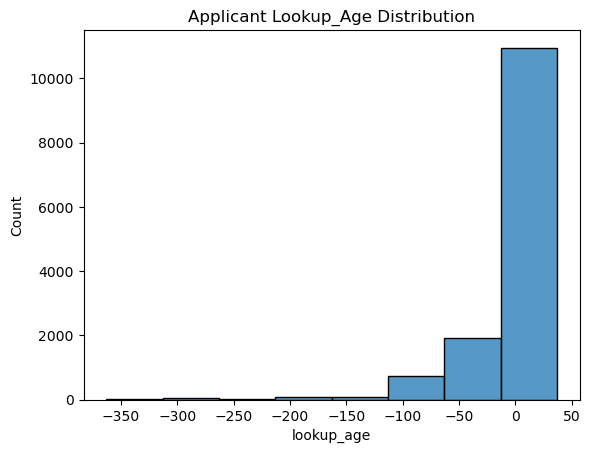

In [195]:
# Check Histogram of Lookup_age for understanding Users' recency Distribution
sns.histplot(data=exp, x='lookup_age',binwidth=50)
plt.title('Applicant Lookup_Age Distribution')

In [196]:
# Rank the recency based on Week, Month, within Half Year, Recall (More than half year), and New periods
age_rank = []
for recency in exp['lookup_age']:
    # Last seen within a week
    if -7 <= recency <= -1:
        age_rank.append('1Week')
        # Last seen within a month
    elif -31 <= recency <= -8:
        age_rank.append('1Month')
        # Last seen more than 1 month ago and within half year
    elif -180 <= recency <= -32:
        age_rank.append('HalfYear')
        # Last seen more than half year
    elif exp['lookup_age'].min() <= recency <= -181:
        age_rank.append('Recall')
        # New to the system
    elif recency == 0:
        age_rank.append('New')

age_rank

['1Month',
 'New',
 '1Week',
 '1Week',
 '1Week',
 'New',
 'New',
 '1Week',
 '1Week',
 'New',
 'New',
 '1Week',
 'HalfYear',
 'New',
 'HalfYear',
 'HalfYear',
 '1Week',
 'New',
 'New',
 'New',
 'New',
 'HalfYear',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 '1Week',
 'New',
 'Recall',
 'New',
 'New',
 'HalfYear',
 'New',
 '1Week',
 'New',
 '1Week',
 'New',
 '1Month',
 'HalfYear',
 'New',
 'New',
 'New',
 'HalfYear',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 '1Month',
 '1Week',
 'New',
 '1Month',
 'New',
 'New',
 'New',
 'HalfYear',
 'New',
 'New',
 'New',
 'HalfYear',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 'New',
 '1Week',
 'New',
 'New',
 'HalfYear',
 '1Month',
 'New',
 'New',
 'New',
 '1Month',
 '1Month',
 'New',
 'HalfYear',
 '1Week',
 'New',
 'New',
 '1Week',
 'New',
 'New',
 'HalfYear',
 'New',
 'HalfYear',
 'New',
 '1Month',
 'New',
 '1Month',
 'New',
 'Hal

In [197]:
exp['age_rank'] = age_rank
exp

,applicant_uuid,application_id,applicant_creation_date,experiment_id,lookup_source,lookup_params,applicant_count,revenue,applicant_email_hash,submit_count,last_seen_date_string,last_seen_date_string_cleaned,last_seen_date_converted,applicant_creation_date_cleaned,applicant_creation_date_converted,lookup_age,age_rank
0,51c65cd8-cc29-48fa-a86c-dec92d24e1bb,b72df58f6fb14737,2023/11/7,6497,internal_1,['email'],1,0.60,1d8c2520459be4b2,1,"""2023-10-24 00:42:59""",2023-10-24 00:42:59,2023-10-24 00:42:59,2023/11/7,2023-11-07,-14.0,1Month
1,1ddfe6e4-100b-4e36-8273-ef545ee43ada,b7073a7feb9a6514,2023/10/27,6497,organic,manual,1,20.00,34add65cbfaad725,1,"""NaT""",NaT,NaT,2023/10/27,2023-10-27,0.0,New
2,c74ed8eb-4832-455b-99ce-cc3925db4874,3cd56372b6c4626c,2023/11/8,6497,internal_1,['email'],1,4.25,593cdf8005c22a64,1,"""2023-11-07 14:43:44""",2023-11-07 14:43:44,2023-11-07 14:43:44,2023/11/8,2023-11-08,-1.0,1Week
3,663befb6-7504-43c9-b2c5-4f4a0a5d7ba5,1ed5966c3651658e,2023/11/12,6102,internal_1,['email'],1,2.65,593cdf8005c22a64,1,"""2023-11-09 11:59:09""",2023-11-09 11:59:09,2023-11-09 11:59:09,2023/11/12,2023-11-12,-3.0,1Week
4,5baed663-354c-4526-b787-b3e8f9389913,7e22a87ef5ec5045,2023/11/3,6102,internal_1,['phone'],1,2.00,040712c1f86dcf0c,1,"""2023-10-28 02:30:40""",2023-10-28 02:30:40,2023-10-28 02:30:40,2023/11/3,2023-11-03,-6.0,1Week
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13843,f80b53f7-e0f7-40dc-93d8-cb1f483941cc,77ebbeded27e1825,2023/11/1,6102,internal_1,['email'],1,4.00,e0dba60bdf234b05,1,"""2023-10-31 03:17:02""",2023-10-31 03:17:02,2023-10-31 03:17:02,2023/11/1,2023-11-01,-1.0,1Week
13844,cd2270d2-9881-47b5-a93b-bcbd5c77813c,NaN,2023/11/9,6102,organic,manual,1,NaN,340fca1a06643e14,0,"""NaT""",NaT,NaT,2023/11/9,2023-11-09,0.0,New
13845,888d3316-5e37-4a22-ae6f-8e4e6d54cd96,423ed88d3cb8b046,2023/10/23,6102,internal_1,['phone'],1,1.20,45d85a0668e7ebfb,1,"""2023-09-24 23:27:37""",2023-09-24 23:27:37,2023-09-24 23:27:37,2023/10/23,2023-10-23,-29.0,1Month
13846,5df5b949-f799-4a36-a8a3-a0b77f446d3e,3b8a19993caa0914,2023/10/12,6102,internal_1,['email'],1,0.00,bc0b3fa6c52a7983,1,"""2023-10-12 00:00:00""",2023-10-12 00:00:00,2023-10-12 00:00:00,2023/10/12,2023-10-12,0.0,New


## Primary & Secondary Metrics Statistics Exploration (Part1)

### Primary & Secondary Metrics Statistics Exploration by Lookup Sources

In [198]:
# Compare Submission Rate and Earnings per Submission from each source
exp.groupby(['lookup_source'])[['revenue','submit_count']].mean()

,revenue,submit_count
lookup_source,,
external_1,21.778337,0.974308
internal_1,6.869694,0.980208
internal_2,10.117294,0.975578
organic,35.128059,0.465637


### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment)

In [199]:
# Compare Submission Rate and Earnings per Submission from Control and Experiment Groups
exp.groupby(['experiment_id'])[['revenue','submit_count']].mean()

,revenue,submit_count
experiment_id,,
6102,17.147681,0.710652
6497,17.281210,0.741929


### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment x Lookup Source)

In [200]:
# Compare Submission Rate and Earnings per Submission from Control and Experiment Groups with segmentation by sources
exp.groupby(['experiment_id','lookup_source'])[['revenue','submit_count']].mean()

revenue  submit_count
experiment_id lookup_source                         
6102          internal_1      6.941224      0.979074
              internal_2      9.726396      0.974333
              organic        34.723040      0.472845
6497          external_1     21.778337      0.974308
              internal_1      6.740973      0.982255
              internal_2     10.818544      0.977819
              organic        35.989952      0.451006

## A/B Test1: External Source vs. Internal & Organic Sources

### Before: Check Metrics Differences between Organic and Lookup Groups

In [201]:
# Create Groups for initial comparison between Users' Submission and EPS by varying implementation of Lookup Sources
exp_organic = exp[exp['lookup_source'] == 'organic']
exp_lookup = exp[exp['lookup_source'] != 'organic']

In [202]:
# Two-Sample T test run on EPS comparison between Organic and Lookup Group
import scipy.stats as stats
alpha = 0.05
t_stat_rev, pvalue_rev = stats.ttest_ind(exp_organic.dropna(subset=['revenue'])['revenue'], exp_lookup.dropna(subset=['revenue'])['revenue'],equal_var=False)
if pvalue_rev > 0.05:
    print(f'The t-statistic from Two-Sample T test on Revenue between New User Group and Lookup Group is {t_stat_rev} with a pvalue of {pvalue_rev}, which is larger than {alpha} and indicates there is no statistically significant difference between the EPS of New User Group and Lookup Group')
elif pvalue_rev <= 0.05:
    print(f'The t-statistic from Two-Sample T test on Revenue between New User Group and Lookup Group is {t_stat_rev} with a pvalue of {pvalue_rev}, which is smaller than {alpha} and indicates there is statistically significant difference between the EPS of New User Group and Lookup Group')

The t-statistic from Two-Sample T test on Revenue between New User Group and Lookup Group is 29.626446382173196 with a pvalue of 5.494956920667473e-174, which is smaller than 0.05 and indicates there is statistically significant difference between the EPS of New User Group and Lookup Group


In [203]:
# Two-Sample Proportion Z test run on Submission Rate comparison between Organic and Lookup Group
from statsmodels.stats.proportion import proportions_ztest

exp_organic_sub = exp_organic['submit_count'].sum()
exp_lookup_sub = exp_lookup['submit_count'].sum()
exp_organic_total = len(exp_organic)
exp_lookup_total = len(exp_lookup)

counts = np.array([exp_organic_sub, exp_lookup_sub])
nobs = np.array([exp_organic_total, exp_lookup_total])

z_stat, z_p_value = proportions_ztest(counts, nobs, alternative='two-sided')
print(z_stat, z_p_value)
if z_p_value >= 0.05:
    print(f'The z-statistic from Two-Sample proportion ztest on Submission Rate between New User Group and Lookup Group is {z_stat} with a pvalue of {z_p_value}, which is larger than {alpha} and indicates there is no statistically significant difference between the Submission Rate of New User Group and Lookup Group')
elif z_p_value < 0.05:
        print(f'The z-statistic from Two-Sample proportion ztest on Submission Rate between New User Group and Lookup Group is {z_stat} with a pvalue of {z_p_value}, which is smaller than {alpha} and indicates there is statistically significant difference between the Submission Rate of New User Group and Lookup Group')

-67.39964244400814 0.0
The z-statistic from Two-Sample proportion ztest on Submission Rate between New User Group and Lookup Group is -67.39964244400814 with a pvalue of 0.0, which is smaller than 0.05 and indicates there is statistically significant difference between the Submission Rate of New User Group and Lookup Group


### A/B Test 1 Dynamics

In [204]:
# Write a Def function to create Segmentaion Groups to compare Control and Experiment Groups' Metrics by Source Types
def create_experiment_groups(exp_df, exp_id, lookup_sources=None):
    """
    Create a filtered DataFrame for an experiment group.

    :param exp_df: The DataFrame containing experiment data.
    :param exp_id: The experiment ID to filter.
    :param lookup_sources: A list of lookup sources to filter. 
    :return: A filtered DataFrame.
    """
    group = exp_df[exp_df['experiment_id'] == exp_id]
    
    if lookup_sources:
        group = group[group['lookup_source'].isin(lookup_sources)]
    
    return group

# Create groups using the function
exp_test_ext = create_experiment_groups(exp, 6497, ['external_1'])
exp_control = create_experiment_groups(exp, 6102)
exp_control_int1 = create_experiment_groups(exp, 6102, ['internal_1'])
exp_control_int2 = create_experiment_groups(exp, 6102, ['internal_2'])
exp_control_org = create_experiment_groups(exp, 6102, ['organic'])


In [205]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest
# Write a Def function to run Two-sample t tests on EPS between Groups with Segmentation
def two_sample_t_test(group1, group2, metric, alpha=0.05):
    """
    Perform a Two-Sample T-Test on a given metric between two groups.
    
    :param group1: First DataFrame (e.g., test group)
    :param group2: Second DataFrame (e.g., control group)
    :param metric: Column name for the metric (e.g., 'revenue')
    :param alpha: Significance level
    """
    group1_metric = group1.dropna(subset=[metric])[metric]
    group2_metric = group2.dropna(subset=[metric])[metric]

    t_stat, p_value = stats.ttest_ind(group1_metric, group2_metric, equal_var=False)
    
    if p_value > alpha:
        print(f'Two-Sample T-Test on {metric} between groups: t-stat = {t_stat:.3f}, p-value = {p_value:.5f} (No Significant Difference)')
    else:
        print(f'Two-Sample T-Test on {metric} between groups: t-stat = {t_stat:.3f}, p-value = {p_value:.5f} (Statistically Significant)')

In [206]:
# Write a Def function to run Two-sample proportion Z test on Submission Rate between Groups with Segmentation
def two_sample_proportion_test(group1, group2, metric, alpha=0.05):
    """
    Perform a Two-Sample Proportion Z-Test on a given metric between two groups.
    
    :param group1: First DataFrame (e.g., test group)
    :param group2: Second DataFrame (e.g., control group)
    :param metric: Column name for the metric (e.g., 'submit_count')
    :param alpha: Significance level
    """
    count1 = group1[metric].sum()
    count2 = group2[metric].sum()
    total1 = len(group1)
    total2 = len(group2)

    counts = np.array([count1, count2])
    nobs = np.array([total1, total2])

    z_stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

    if p_value > alpha:
        print(f'Proportion Z-Test on {metric} between groups: z-stat = {z_stat:.3f}, p-value = {p_value:.5f} (No Significant Difference)')
    else:
        print(f'Proportion Z-Test on {metric} between groups: z-stat = {z_stat:.3f}, p-value = {p_value:.5f} (Statistically Significant)')


### A/B Test 1 Results

#### Submission Rate Hypothesis Test

In [207]:
# Define test-control group pairs
test_control_pairs = [
    (exp_test_ext, exp_control, "Overall Control"),
    (exp_test_ext, exp_control_int1, "Segment 1 - Internal Source 1"),
    (exp_test_ext, exp_control_int2, "Segment 2 - Internal Source 2"),
    (exp_test_ext, exp_control_org, "Segment 3 - Organic Source"),
]

# Run tests for each pair
for test_group, control_group, group_name in test_control_pairs:
    print(f"\n--- Running Tests for {group_name} ---")
    
    # Proportion Z-Test for Submission Rate
    two_sample_proportion_test(test_group, control_group, metric='submit_count')


--- Running Tests for Overall Control ---
Proportion Z-Test on submit_count between groups: z-stat = 12.916, p-value = 0.00000 (Statistically Significant)

--- Running Tests for Segment 1 - Internal Source 1 ---
Proportion Z-Test on submit_count between groups: z-stat = -0.685, p-value = 0.49346 (No Significant Difference)

--- Running Tests for Segment 2 - Internal Source 2 ---
Proportion Z-Test on submit_count between groups: z-stat = -0.003, p-value = 0.99776 (No Significant Difference)

--- Running Tests for Segment 3 - Organic Source ---
Proportion Z-Test on submit_count between groups: z-stat = 21.443, p-value = 0.00000 (Statistically Significant)


#### Earnings per Submission Hypothesis Test

In [208]:
# Run tests for each pair
for test_group, control_group, group_name in test_control_pairs:
    print(f"\n--- Running Tests for {group_name} ---")
    
    # T-Test for Revenue
    two_sample_t_test(test_group, control_group, metric='revenue')



--- Running Tests for Overall Control ---
Two-Sample T-Test on revenue between groups: t-stat = 2.765, p-value = 0.00588 (Statistically Significant)

--- Running Tests for Segment 1 - Internal Source 1 ---
Two-Sample T-Test on revenue between groups: t-stat = 8.982, p-value = 0.00000 (Statistically Significant)

--- Running Tests for Segment 2 - Internal Source 2 ---
Two-Sample T-Test on revenue between groups: t-stat = 6.850, p-value = 0.00000 (Statistically Significant)

--- Running Tests for Segment 3 - Organic Source ---
Two-Sample T-Test on revenue between groups: t-stat = -6.755, p-value = 0.00000 (Statistically Significant)


## Primary & Secondary Metrics Statistics Exploration (Part2)

### Primary & Secondary Metrics Statistics Exploration by Age Group

In [209]:
# Compare Submission Rate and Earnings per Submission from different age groups (based on recency)
exp.groupby(['age_rank'])[['revenue','submit_count']].mean()

,revenue,submit_count
age_rank,,
1Month,8.517544,0.976438
1Week,3.639644,0.976627
HalfYear,15.464821,0.982662
New,23.954513,0.578509
Recall,27.301974,0.974359


### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment x Age Group)

In [210]:
# Compare Submission Rate and Earnings per Submission from Control and Experiment Groups with segmentation by age groups
exp.groupby(['experiment_id','age_rank'])[['revenue','submit_count']].mean()

revenue  submit_count
experiment_id age_rank                         
6102          1Month     7.634328      0.975295
              1Week      3.502263      0.980620
              HalfYear  15.317102      0.978351
              New       24.341169      0.576178
6497          1Month    10.118263      0.978516
              1Week      3.900000      0.969147
              HalfYear  15.638317      0.987775
              New       23.221742      0.582977
              Recall    27.301974      0.974359

### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment x Age Group & Lookup Source)

In [211]:
# Compare Submission Rate and Earnings per Submission from Control and Experiment Groups with segmentation by age groups and sources
exp.groupby(['experiment_id','age_rank','lookup_source'])[['revenue','submit_count']].mean()

revenue  submit_count
experiment_id age_rank lookup_source                         
6102          1Month   internal_1      6.904478      0.971831
                       internal_2      9.944404      0.986425
              1Week    internal_1      2.976185      0.986811
                       internal_2      5.793069      0.954545
              HalfYear internal_1     15.381121      0.982609
                       internal_2     15.156937      0.967857
              New      internal_1      4.228105      0.975000
                       internal_2      6.863653      0.985455
                       organic        34.723040      0.472845
6497          1Month   external_1     33.269333      0.937500
                       internal_1      8.500262      0.976982
                       internal_2     12.722212      0.990476
              1Week    external_1     17.195714      0.875000
                       internal_1      2.731565      0.981651
                       internal_2      7.312500      0.929293
              HalfYear external_1     20.809585      0.983673
                       internal_1     12.950278      0.987531
                       internal_2     14.575088      0.994186
              New      external_1     11.717324      0.972603
                       internal_1      3.966647      0.982659
                       internal_2      7.622284      0.981818
                       organic        35.989952      0.451006
              Recall   external_1     27.301974      0.974359

## A/B Test2: External Source vs. Internal & Organic Sources with Age Group Segmentation

### A/B Test 2 Dynamics

In [212]:
# Filter experiment dataset into age-group-based Dataframe prepare for further segmentation analysis
exp_weekly = exp[exp['age_rank'] == '1Week']
exp_monthly = exp[exp['age_rank'] == '1Month']
exp_halfyr = exp[exp['age_rank'] == 'HalfYear']
exp_recall = exp[exp['age_rank'] == 'Recall']
exp_new = exp[exp['age_rank'] == 'New']

In [213]:
# Create Experiment Group of Users from External Source by age groups
exp_ext_weekly = exp_weekly[(exp_weekly['experiment_id'] == 6497) & (exp_weekly['lookup_source'] == 'external_1')]
exp_ext_monthly = exp_monthly[(exp_monthly['experiment_id'] == 6497) & (exp_monthly['lookup_source'] == 'external_1')]
exp_ext_halfyr = exp_halfyr[(exp_halfyr['experiment_id'] == 6497) & (exp_halfyr['lookup_source'] == 'external_1')]
exp_ext_recall = exp_recall[(exp_recall['experiment_id'] == 6497) & (exp_recall['lookup_source'] == 'external_1')]
exp_ext_new = exp_new[(exp_new['experiment_id'] == 6497) & (exp_new['lookup_source'] == 'external_1')]

# Create Experiment Group of Users from Internal 1 Source by age groups
exp_int1_weekly = exp_weekly[(exp_weekly['experiment_id'] == 6102) & (exp_weekly['lookup_source'] == 'internal_1')]
exp_int1_monthly = exp_monthly[(exp_monthly['experiment_id'] == 6102) & (exp_monthly['lookup_source'] == 'internal_1')]
exp_int1_halfyr = exp_halfyr[(exp_halfyr['experiment_id'] == 6102) & (exp_halfyr['lookup_source'] == 'internal_1')]
exp_int1_new = exp_new[(exp_new['experiment_id'] == 6102) & (exp_new['lookup_source'] == 'internal_1')]

# Create Experiment Group of Users from Internal 2 Source by age groups
exp_int2_weekly = exp_weekly[(exp_weekly['experiment_id'] == 6102) & (exp_weekly['lookup_source'] == 'internal_2')]
exp_int2_monthly = exp_monthly[(exp_monthly['experiment_id'] == 6102) & (exp_monthly['lookup_source'] == 'internal_2')]
exp_int2_halfyr = exp_halfyr[(exp_halfyr['experiment_id'] == 6102) & (exp_halfyr['lookup_source'] == 'internal_2')]
exp_int2_new = exp_new[(exp_new['experiment_id'] == 6102) & (exp_new['lookup_source'] == 'internal_2')]

# Create Experiment Group of Users from Organic Source by age groups
exp_org_new = exp_new[(exp_new['experiment_id'] == 6102) & (exp_new['lookup_source'] == 'organic')]

In [214]:
# Define test-control group pairs
test_control_pairs_age = [
    (exp_ext_weekly, exp_int1_weekly, "1Week - Ext vs. Internal 1"),
    (exp_ext_weekly, exp_int2_weekly, "1Week - Ext vs. Internal 2"),
    (exp_ext_monthly, exp_int1_monthly, "1Month - Ext vs. Internal 1"),
    (exp_ext_monthly, exp_int2_monthly, "1Month - Ext vs. Internal 2"),
    (exp_ext_halfyr, exp_int1_halfyr, "HalfYear - Ext vs. Internal 1"),
    (exp_ext_halfyr, exp_int2_halfyr, "HalfYear - Ext vs. Internal 2"),
    (exp_ext_new, exp_int1_new, "New - Ext vs. Internal 1"),
    (exp_ext_new, exp_int2_new, "New - Ext vs. Internal 2"),
    (exp_ext_new, exp_org_new, "New - Ext vs. Organic"),
]

### A/B Test 2 Results

#### Submission Rate Hypothesis Test

In [215]:
# Run tests for each pair
for test_group, control_group, group_name in test_control_pairs_age:
    print(f"\n--- Running Tests for {group_name} ---")
    
    # Proportion Z-Test for Submission Rate
    two_sample_proportion_test(test_group, control_group, metric='submit_count')


--- Running Tests for 1Week - Ext vs. Internal 1 ---
Proportion Z-Test on submit_count between groups: z-stat = -3.610, p-value = 0.00031 (Statistically Significant)

--- Running Tests for 1Week - Ext vs. Internal 2 ---
Proportion Z-Test on submit_count between groups: z-stat = -1.386, p-value = 0.16574 (No Significant Difference)

--- Running Tests for 1Month - Ext vs. Internal 1 ---
Proportion Z-Test on submit_count between groups: z-stat = -0.810, p-value = 0.41777 (No Significant Difference)

--- Running Tests for 1Month - Ext vs. Internal 2 ---
Proportion Z-Test on submit_count between groups: z-stat = -1.467, p-value = 0.14235 (No Significant Difference)

--- Running Tests for HalfYear - Ext vs. Internal 1 ---
Proportion Z-Test on submit_count between groups: z-stat = 0.110, p-value = 0.91210 (No Significant Difference)

--- Running Tests for HalfYear - Ext vs. Internal 2 ---
Proportion Z-Test on submit_count between groups: z-stat = 1.163, p-value = 0.24465 (No Significant Diff

#### Earnings per Submission Hypothesis Test

In [216]:
# Run tests for each pair
for test_group, control_group, group_name in test_control_pairs_age:
    print(f"\n--- Running Tests for {group_name} ---")
    
    # T-Test for Revenue
    two_sample_t_test(test_group, control_group, metric='revenue')



--- Running Tests for 1Week - Ext vs. Internal 1 ---
Two-Sample T-Test on revenue between groups: t-stat = 1.646, p-value = 0.12365 (No Significant Difference)

--- Running Tests for 1Week - Ext vs. Internal 2 ---
Two-Sample T-Test on revenue between groups: t-stat = 1.313, p-value = 0.21128 (No Significant Difference)

--- Running Tests for 1Month - Ext vs. Internal 1 ---
Two-Sample T-Test on revenue between groups: t-stat = 2.123, p-value = 0.05191 (No Significant Difference)

--- Running Tests for 1Month - Ext vs. Internal 2 ---
Two-Sample T-Test on revenue between groups: t-stat = 1.868, p-value = 0.08220 (No Significant Difference)

--- Running Tests for HalfYear - Ext vs. Internal 1 ---
Two-Sample T-Test on revenue between groups: t-stat = 2.039, p-value = 0.04210 (Statistically Significant)

--- Running Tests for HalfYear - Ext vs. Internal 2 ---
Two-Sample T-Test on revenue between groups: t-stat = 1.919, p-value = 0.05557 (No Significant Difference)

--- Running Tests for New

## Recommendations

**Experiment Decisions: Continue the Test with Modified Research**

1. External Sourcing boosts EPS against Internal 1 & 2 and maintains relatively same quality of application submission rate compared to Internal 1 & 2. However, External Sourcing EPS is still significantly lower than Organic EPS, which requires prioritization on EPS over Submission Rate with Modified Experiment

3. More data needed to further segment age group users to identify whether statistically significant difference will occur from External Sourced Users against Internal 1, 2, & Organic

**Strategic Decisions:**
1. **Organic - UI/UX or Application Friction Optimization:** Lower Submission Rate implies that many organic users drop off before completing an application, possibly due to a lack of pre-populated data or friction in the process.

2. **External - Expanding Coverage from Email to more Sourcing Parameters:** Given the strong EPS lift among new users, prioritize expansion of External1 coverage to enrich user data

3. **Age Group - Reengage Recall Users with Email/SMS Campaigns:** External1 boosts earnings among this segments and exclusively cover these users against either Internal or Organic Source; increase personalized messaging and incentives to encourage reactivation

## Discussions: Lookup_Params Impact

### Primary & Secondary Metrics Statistics Exploration (Part3)

### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment x Lookup Source & Lookup Params)

In [217]:
# Discussion: Params Differential Impact on Metrics (pt1)
exp.groupby(['experiment_id','lookup_params'])[['revenue','submit_count']].mean()
exp.groupby(['experiment_id','lookup_source','lookup_params'])[['revenue','submit_count']].mean()

revenue  submit_count
experiment_id lookup_source lookup_params                         
6102          internal_1    ['email']       6.726924      0.978751
                            ['ip']          3.480000      1.000000
                            ['phone']      15.720127      0.987500
              internal_2    ['email']      10.491248      0.981157
                            ['ip']          5.517000      0.965517
                            ['phone']      10.123125      0.930233
              organic       manual         34.723040      0.472845
6497          external_1    ['email']      21.778337      0.974308
              internal_1    ['email']       6.555391      0.981711
                            ['ip']          9.640909      1.000000
                            ['phone']      13.494878      1.000000
              internal_2    ['email']      11.656343      0.977376
                            ['ip']          6.030317      0.984375
                            ['phone']       9.045882      0.971429
              organic       manual         35.989952      0.451006

### Primary & Secondary Metrics Statistics Exploration (Control vs. Experiment x Age Group x Lookup Source & Lookup Params)

In [219]:
# Discussion: Params Differential Impact on Metrics (pt2)
exp.groupby(['experiment_id','age_rank','lookup_params'])[['revenue','submit_count']].mean()
exp.groupby(['experiment_id','age_rank','lookup_source','lookup_params'])[['revenue','submit_count']].mean()

revenue  submit_count
experiment_id age_rank lookup_source lookup_params                         
6102          1Month   internal_1    ['email']       6.819080      0.972141
                                     ['ip']          1.833333      1.000000
                                     ['phone']       9.897500      0.960000
                       internal_2    ['email']      10.439408      0.994118
                                     ['ip']          5.560000      0.941176
                                     ['phone']      13.276471      1.000000
              1Week    internal_1    ['email']       2.972733      0.986335
                                     ['ip']          3.966667      1.000000
                                     ['phone']       2.667500      1.000000
                       internal_2    ['email']       6.685548      0.973333
                                     ['ip']          3.013462      1.000000
                                     ['phone']       2.379412      0.772727
              HalfYear internal_1    ['email']      14.638675      0.981846
                                     ['ip']          3.000000      1.000000
                                     ['phone']      33.032143      1.000000
                       internal_2    ['email']      16.558592      0.967136
                                     ['ip']          7.514839      0.939394
                                     ['phone']      13.632353      1.000000
              New      internal_1    ['email']       4.232556      0.974753
                                     ['ip']          4.000000      1.000000
                                     ['phone']       3.728571      1.000000
                       internal_2    ['email']       7.195673      0.990476
                                     ['ip']          5.551961      0.980769
                                     ['phone']       6.683333      0.923077
                       organic       manual         34.723040      0.472845
6497          1Month   external_1    ['email']      33.269333      0.937500
                       internal_1    ['email']       8.399103      0.976127
                                     ['ip']          1.900000      1.000000
                                     ['phone']      13.684545      1.000000
                       internal_2    ['email']      13.323372      0.988506
                                     ['ip']         11.558333      1.000000
                                     ['phone']       6.433333      1.000000
              1Week    external_1    ['email']      17.195714      0.875000
                       internal_1    ['email']       2.731017      0.980998
                                     ['ip']          6.812500      1.000000
                                     ['phone']       1.268182      1.000000
                       internal_2    ['email']       8.152632      0.926829
                                     ['ip']          3.488889      0.900000
                                     ['phone']       3.107143      1.000000
              HalfYear external_1    ['email']      20.809585      0.983673
                       internal_1    ['email']      12.344723      0.986979
                                     ['ip']         32.050000      1.000000
                                     ['phone']      25.704000      1.000000
                       internal_2    ['email']      15.461748      1.000000
                                     ['ip']          3.918182      1.000000
                                     ['phone']      14.012353      0.944444
              New      external_1    ['email']      11.717324      0.972603
                       internal_1    ['email']       3.989563      0.982456
                                     ['ip']          4.500000      1.000000
                                     ['phone']       0.812500      1.000000
                       internal_2    ['email']       8.339370      0.976923
                          

In [223]:
exp.groupby(['experiment_id','age_rank','lookup_source']).count()

applicant_uuid  application_id  \
experiment_id age_rank lookup_source                                   
6102          1Month   internal_1                710             690   
                       internal_2                221             218   
              1Week    internal_1                834             823   
                       internal_2                198             189   
              HalfYear internal_1                690             678   
                       internal_2                280             271   
              New      internal_1                920             897   
                       internal_2                275             271   
                       organic                  4640            2194   
6497          1Month   external_1                 16              15   
                       internal_1                391             382   
                       internal_2                105             104   
              1Week    external_1                 16              14   
                       internal_1                436             428   
                       internal_2                 99              92   
              HalfYear external_1                245             241   
                       internal_1                401             396   
                       internal_2                172             171   
              New      external_1                 73              71   
                       internal_1                519             510   
                       internal_2                165             162   
                       organic                  2286            1031   
              Recall   external_1                156             152   

                                      applicant_creation_date  lookup_params  \
experiment_id age_rank lookup_source                                           
6102          1Month   internal_1                         710            710   
                       internal_2                         221            221   
              1Week    internal_1                         834            834   
                       internal_2                         198            198   
              HalfYear internal_1                         690            690   
                       internal_2                         280            280   
              New      internal_1                         920            920   
                       internal_2                         275            275   
                       organic                           4640           4640   
6497          1Month   external_1                          16             16   
                       internal_1                         391            391   
                       internal_2                         105            105   
              1Week    external_1                          16             16   
                       internal_1                         436            436   
                       internal_2                          99             99   
              HalfYear external_1                         245            245   
                       internal_1                         401            401   
                       internal_2                         172            172   
              New      external_1                          73             73   
                       internal_1                         519            519   
                       internal_2                         165            165   
                       organic                           2286           2286   
              Recall   external_1                         156            156   

                                      applicant_count  revenue  \
experiment_id age_rank lookup_source                             
6102          1Month   internal_1                 710      690   
                       internal_2     